<a id='sec0'></a>
# Evaluating RandomForest using TL-RUS undersampled dataset

- Use RandomForestClassifier with max_depth=40
- Train the model on undersampled set and test it on the imbalanced set with the original class ratio
- Do the above with multiple rounds of undersampling and test to make sure results are similar

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from collections import Counter

import my_scoring_functions as msf

%matplotlib inline

# Setting up Data (This time tried to label subscriber as 0)

In [2]:
data = pd.read_csv('../data/for_predictions/2015-2017_usertype_tomeklinks.csv')

In [3]:
data = data.dropna()
del data['Unnamed: 0']

In [4]:
data.head()

,tripduration,start station latitude,start station longitude,end station latitude,end station longitude,start_year,start_month,start_day,start_hour,start_dayofweek,birth year,gender,usertype
0,1346.0,40.750020,-73.969053,40.722293,-73.991475,2015.0,1.0,1.0,0.0,3.0,1960.0,2.0,0
1,363.0,40.743174,-74.003664,40.739355,-73.999318,2015.0,1.0,1.0,0.0,3.0,1963.0,1.0,0
2,346.0,40.740964,-73.986022,40.749013,-73.988484,2015.0,1.0,1.0,0.0,3.0,1974.0,1.0,0
3,182.0,40.683178,-73.965964,40.688515,-73.964763,2015.0,1.0,1.0,0.0,3.0,1969.0,1.0,0
4,969.0,40.745168,-73.986831,40.726218,-73.983799,2015.0,1.0,1.0,0.0,3.0,1977.0,1.0,0


In [5]:
data.describe().astype(int)

,tripduration,start station latitude,start station longitude,end station latitude,end station longitude,start_year,start_month,start_day,start_hour,start_dayofweek,birth year,gender,usertype
count,22950465,22950465,22950465,22950465,22950465,22950465,22950465,22950465,22950465,22950465,22950465,22950465,22950465
mean,808,40,-73,40,-73,2015,6,15,13,2,1977,1,0
std,7030,0,0,0,0,0,3,8,4,1,11,0,0
min,60,0,-74,0,-74,2015,1,1,0,0,1885,0,0
25%,360,40,-73,40,-73,2015,4,8,9,1,1969,1,0
50%,574,40,-73,40,-73,2016,7,16,14,3,1980,1,0
75%,933,40,-73,40,-73,2016,10,23,18,4,1986,1,0
max,8933552,40,0,40,0,2017,12,31,23,6,2001,2,1


In [6]:
# Create X and y for sklearn
X = data[data.columns[:-1]].astype(np.float)
y = data['usertype'].astype(np.int)

In [7]:
X.shape

(22950465, 12)

In [8]:
y.shape

(22950465,)

# Train on undersampled set, test on regular set (multiple rounds)
- Use noise-removed dataset from Tomek Links
- First, split the dataset into train and test sets
- Randomly undersample the majority on the trainset only
- Train the classifier on undersampled set, test on the non-resampled test set

Average accuracy: 0.865376 +/- 0.000508 (n=5)
Average AP Score: 0.169333 +/- 0.002651 (n=5)
CPU times: user 4min 43s, sys: 30.7 s, total: 5min 14s
Wall time: 3min 4s


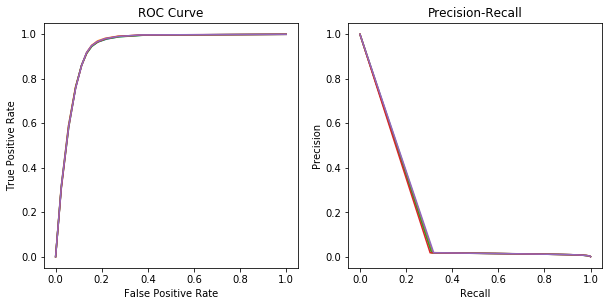

In [9]:
%%time

# Set up basic parameters and data containers
n = 5
test_size = 0.4
accuracies = []
aps = []

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))

# Split the sample first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

for i in range(n):
    
    # Undersample the majority for train set only
    rus = RandomUnderSampler(ratio='majority')
    X_res, y_res = rus.fit_sample(X_train, y_train)
    
    # Train RandomForest on Undersampled train set
    clf = RandomForestClassifier(max_depth=40, n_jobs=4)
    clf.fit(X_res, y_res)
    
    # Predict/score on X_test and y_test
    result = msf.score_clf(clf, X_test, y_test, X_train=X_res, y_train=y_res)
    accuracies.append(result['scores']['accuracy'])
    aps.append(result['scores']['average_precision_score'])
    
    # Plot ROC curve
    fpr = result['scores']['roc_curve'][0]
    tpr = result['scores']['roc_curve'][1]
    ax1.plot(fpr, tpr)
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve')
    
    # Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])

    ax2.plot(recall, precision)
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall')

print('Average accuracy: %f +/- %f (n=%d)' % (np.mean(accuracies), np.std(accuracies), n))
print('Average AP Score: %f +/- %f (n=%d)' % (np.mean(aps), np.std(aps), n))

In [10]:
# Get result from the last classifier teseted
result = msf.score_clf2(clf, X_test, y_test)

In [11]:
# Print the result from the last classifier tested
feature_labels = data.columns[:-1]
msf.print_clf_scores2(result, trainset=False, feature_labels=feature_labels)

==== Classifier Metrics on Test Set ====
Accuracy: 0.866057
Precision: 0.010502
Recall: 0.917200
F-Score: 0.020766
Brier Score: 0.105763
Average Precision Score: 0.172670
Confusion Matrix:  [[7937522 1228449]
 [   1177   13038]]
--------------- Feature Importances ---------------
 1) start_month          0.386977
 2) start_year           0.220671
 3) start_day            0.048968
 4) start_dayofweek      0.046907
 5) tripduration         0.046130
 6) start station latitude 0.043122
 7) end station latitude 0.042423
 8) end station longitude 0.040913
 9) start station longitude 0.040735
10) start_hour           0.040432
11) birth year           0.036800
12) gender               0.005921


